In [1]:
# load modules 
import xarray as xr
from matplotlib import pyplot as plt
from xgcm import Grid, generate_grid_ds
import numpy as np
%matplotlib inline

In [2]:
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

In [3]:
Model_Tav = xr.open_dataset('./outputs_ncfiles/Model_Tav.nc')

In [70]:
Model_Tav

<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41)
Coordinates:
  * XC                   (XC) float32 2500.0 7500.0 ... 1992500.0 1997500.0
  * YC                   (YC) float32 2500.0 7500.0 ... 1992500.0 1997500.0
  * XG                   (XG) float32 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * YG                   (YG) float32 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * Z                    (Z) float32 -5.0 -15.0 -25.0 ... -2830.5 -2933.5
  * Zp1                  (Zp1) float32 0.0 -10.0 -20.0 ... -2882.0 -2985.0
  * Zu                   (Zu) float32 -10.0 -20.0 -30.0 ... -2882.0 -2985.0
  * Zl                   (Zl) float32 0.0 -10.0 -20.0 ... -2779.0 -2882.0
    rA                   (YC, XC) float32 ...
    dxG                  (YG, XC) float32 ...
    dyG                  (YC, XG) float32 ...
    Depth                (YC, XC) float32 ...
    rAz   

In [88]:
Lcoarse = 50e3
diff_tensor = xr.open_dataset('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km.nc')

In [89]:
from xgcm import Grid, generate_grid_ds

In [136]:
# define a grid for taking gradients on coarse grid
grid_ds = xr.Dataset()
grid_ds['TRAC01'] = Trac_coarse['TRAC01']
grid_ds['wVeltave'] = Model_Tav['wVeltave']
grid_ds = grid_ds.drop(['wVeltave','XC','YC']).isel(XC=0, YC=0)
ds = generate_grid_ds(grid_ds, {'X': 'XCcoarse', 'Y':'YCcoarse'})
grid = Grid(ds, periodic='X')

In [137]:
def divergence(flux, grid, Lcoarse):
    
    div = grid.interp(grid.diff(flux.UpCp, 'X')/Lcoarse, 'X') + \
              grid.interp(grid.diff(flux.VpCp, 'Y', boundary='extend')/Lcoarse, 'Y', boundary='extend') + \
             -grid.interp(grid.diff(flux.WpCp, 'Z', boundary='extend'), 'Z', boundary='extend')/ flux.drF
                
    return div           

In [138]:
from funcs import *

In [139]:
fluxT = xr.Dataset({'UpCp':T_coarse.UpTp, 'VpCp':T_coarse.VpTp, 'WpCp':T_coarse.WpTp})
gradT = xr.Dataset({'dCdx':T_coarse.T_X, 'dCdy':T_coarse.T_Y, 'dCdz':T_coarse.T_Z})

In [140]:
def flux_reconstruct(tensor, flux, grads):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy + tensor.sel(i=0, j=2)*grads.dCdz)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy + tensor.sel(i=1, j=2)*grads.dCdz)
    recWflux = -(tensor.sel(i=2, j=0)*grads.dCdx + tensor.sel(i=2, j=1)*grads.dCdy + tensor.sel(i=2, j=2)*grads.dCdz)

    errU = np.abs(flux.UpCp - recUflux)/np.abs(flux.UpCp)
    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
                                'errU':errU, 'errV':errV, 'errW':errW})
    
    return flux_rec

In [141]:
frb = flux_reconstruct(diff_tensor.Kcorr, fluxT, gradT)
frb_AT = flux_reconstruct(diff_tensor.ATcorr, fluxT, gradT) 
frb_ST = flux_reconstruct(diff_tensor.STcorr, fluxT, gradT) 

In [142]:
div_frb = divergence(frb,grid,Lcoarse)
div_frb_AT = divergence(frb_AT,grid,Lcoarse)
div_frb_ST = divergence(frb_ST,grid,Lcoarse)
div_fluxT = divergence(fluxT, grid, Lcoarse)

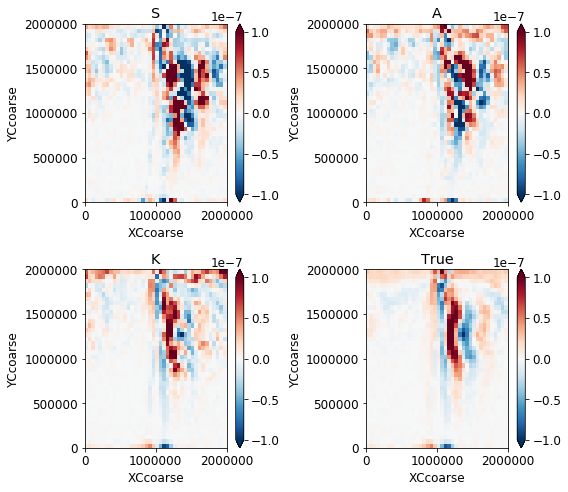

In [143]:
plt.figure(figsize=(8,7))

plt.subplot(221)
div_frb_ST.sel(Z=-1000, method='nearest').plot(vmin=-1e-7)
plt.title('S')

plt.subplot(222)
div_frb_AT.sel(Z=-1000, method='nearest').plot(vmin=-1e-7)
plt.title('A')

plt.subplot(223)
div_frb.sel(Z=-1000, method='nearest').plot(vmin=-1e-7)
plt.title('K')

plt.subplot(224)
div_fluxT.sel(Z=-1000, method='nearest').plot(vmin=-1e-7)
plt.title('True')

plt.tight_layout()

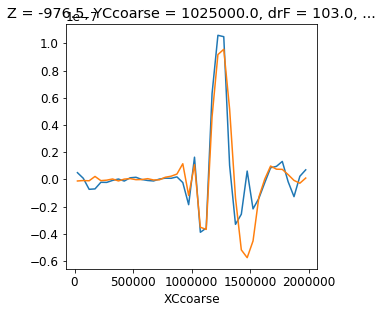

In [144]:
div_frb.sel(YCcoarse=1e6, Z=-1000, method='nearest').plot()
div_fluxT.sel(YCcoarse=1e6, Z=-1000, method='nearest').plot()

In [145]:
psiX_TEM = - T_coarse.UpTp/T_coarse.T_Z 
psiY_TEM = - T_coarse.VpTp/T_coarse.T_Z 

In [146]:
extraX = -grid.interp( grid.diff(Vels_coarse.U * T_coarse.TpTp/2/ T_coarse.T_Z, 'Z', boundary='extend'),
                      'Z', boundary='extend')/ T_coarse.drF/ T_coarse.T_Z
extraY = -grid.interp( grid.diff(Vels_coarse.V * T_coarse.TpTp/2/ T_coarse.T_Z, 'Z', boundary='extend'),
                      'Z', boundary='extend')/ T_coarse.drF/ T_coarse.T_Z

In [147]:
psiX_TRM = psiX_TEM + extraX
psiY_TRM = psiY_TEM + extraY

In [148]:
uT_TEM = - psiX_TEM*T_coarse.T_Z
vT_TEM = - psiY_TEM*T_coarse.T_Z
wT_TEM = - (-psiX_TEM*T_coarse.T_X  -psiY_TEM*T_coarse.T_Y)

In [149]:
uT_TRM = - psiX_TRM*T_coarse.T_Z
vT_TRM = - psiY_TRM*T_coarse.T_Z
wT_TRM = - (-psiX_TRM*T_coarse.T_X  -psiY_TRM*T_coarse.T_Y)

In [150]:
fluxT_TRM = xr.Dataset({'UpCp':uT_TRM, 'VpCp':vT_TRM, 'WpCp':wT_TRM})
fluxT_TEM = xr.Dataset({'UpCp':uT_TEM, 'VpCp':vT_TEM, 'WpCp':wT_TEM})

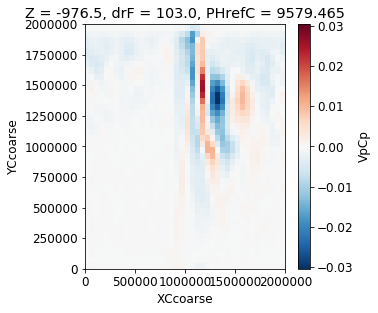

In [180]:
fluxT_TRM.VpCp.sel(Z=-1000, method='nearest').plot()

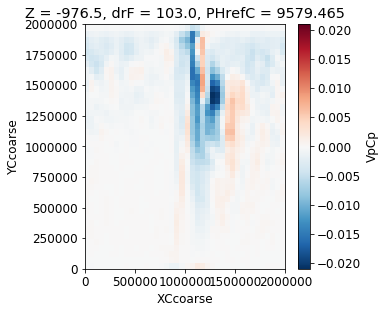

In [181]:
fluxT_TEM.VpCp.sel(Z=-1000, method='nearest').plot()

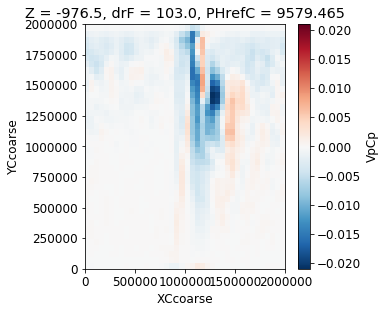

In [182]:
fluxT.VpCp.sel(Z=-1000, method='nearest').plot()

In [151]:
div_TRM = divergence(fluxT_TRM, grid, Lcoarse)
div_TEM = divergence(fluxT_TEM, grid, Lcoarse)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1005: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)


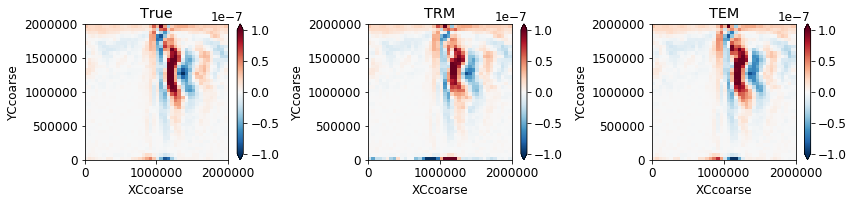

In [152]:
plt.figure(figsize=(12,3))
plt.subplot(131)
div_fluxT.sel(Z=-1000, method='nearest').plot(vmin=-1e-7)
plt.title('True')

plt.subplot(132)
div_TRM.sel(Z=-1000, method='nearest').plot(vmin=-1e-7)
plt.title('TRM')

plt.subplot(133)
div_TEM.sel(Z=-1000, method='nearest').plot(vmin=-1e-7)
plt.title('TEM')

plt.tight_layout()

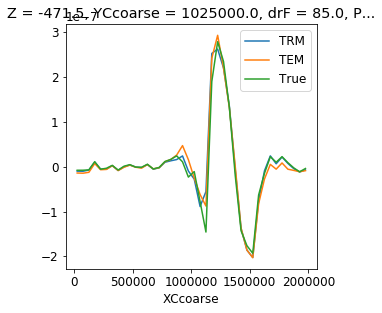

In [155]:
div_TRM.sel(YCcoarse=1e6, Z=-500, method='nearest').plot(label='TRM')
div_TEM.sel(YCcoarse=1e6, Z=-500, method='nearest').plot(label='TEM')
div_fluxT.sel(YCcoarse=1e6, Z=-500, method='nearest').plot(label='True')
plt.legend()

In [157]:
grid_nosav = Grid(Model_Tav, periodic='X')
UpTp = grid_nosav.interp(Model_Tav.UTtave,'X') - grid_nosav.interp(Model_Tav.uVeltave, 'X')*Model_Tav.Ttave
VpTp = grid_nosav.interp(Model_Tav.VTtave,'Y', boundary='extend') - grid_nosav.interp(Model_Tav.vVeltave, 'Y', boundary='extend')*Model_Tav.Ttave
WpTp = grid_nosav.interp(Model_Tav.WTtave,'Z', boundary='extend') - grid_nosav.interp(Model_Tav.wVeltave, 'Z', boundary='extend')*Model_Tav.Ttave
fluxT_nosav = xr.Dataset({'UpCp':UpTp, 'VpCp':VpTp, 'WpCp':WpTp})

In [159]:
T_z = -grid_nosav.interp(grid_nosav.diff(Model_Tav.Ttave, 'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF
T_y =  grid_nosav.interp(grid_nosav.diff(Model_Tav.Ttave, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3
T_x =  grid_nosav.interp(grid_nosav.diff(Model_Tav.Ttave, 'X'), 'X')/5e3

In [160]:
div_fluxT_nosav =divergence(fluxT_nosav,grid_nosav,5e3)

In [162]:
psiX_TEM_nosav = - UpTp/T_z
psiY_TEM_nosav = - VpTp/T_z

In [163]:
phi_nosav = (Model_Tav.TTtave - Model_Tav.Ttave**2)/2
Umean = grid_nosav.interp(Model_Tav.uVeltave, 'X')
Vmean = grid_nosav.interp(Model_Tav.vVeltave, 'Y', boundary='extend')

In [165]:
extraX_nosav = -grid_nosav.interp( grid_nosav.diff(
                       Umean * phi_nosav/ T_z,
                      'Z', boundary='extend'),
                      'Z', boundary='extend')/ Model_Tav.drF/ T_z

extraY_nosav = -grid_nosav.interp( grid_nosav.diff(
                       Vmean * phi_nosav/ T_z,
                      'Z', boundary='extend'),
                      'Z', boundary='extend')/ Model_Tav.drF/ T_z


/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1005: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1005: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)


In [166]:
psiX_TRM_nosav = psiX_TEM_nosav + extraX_nosav
psiY_TRM_nosav = psiY_TEM_nosav + extraY_nosav

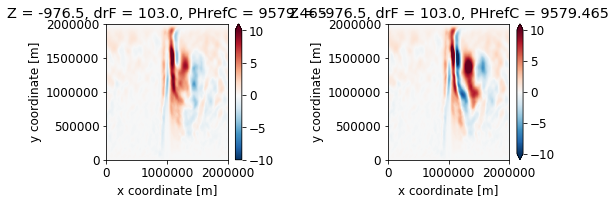

In [177]:
plt.figure(figsize=(8,3))

plt.subplot(121)
psiY_TEM_nosav.sel(Z=-1000, method='nearest').plot(vmin=-10)

plt.subplot(122)
psiY_TRM_nosav.sel(Z=-1000, method='nearest').plot(vmin=-10)

plt.tight_layout()

In [168]:
uT_TEM_nosav = - psiX_TEM_nosav * T_z
vT_TEM_nosav = - psiY_TEM_nosav * T_z
wT_TEM_nosav = - (- psiX_TEM_nosav * T_x  - psiY_TEM_nosav *T_y)

uT_TRM_nosav = - psiX_TRM_nosav * T_z
vT_TRM_nosav = - psiY_TRM_nosav * T_z
wT_TRM_nosav = - (- psiX_TRM_nosav * T_x  - psiY_TRM_nosav *T_y)

In [169]:
fluxT_TRM_nosav = xr.Dataset({'UpCp':uT_TRM_nosav, 'VpCp':vT_TRM_nosav, 'WpCp':wT_TRM_nosav})
fluxT_TEM_nosav = xr.Dataset({'UpCp':uT_TEM_nosav, 'VpCp':vT_TEM_nosav, 'WpCp':wT_TEM_nosav})

In [170]:
div_TRM_nosav = divergence(fluxT_TRM_nosav, grid_nosav, 5e3)
div_TEM_nosav = divergence(fluxT_TEM_nosav, grid_nosav, 5e3)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1005: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left


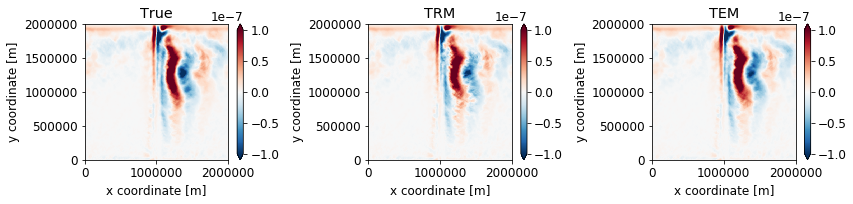

In [171]:
plt.figure(figsize=(12,3))
plt.subplot(131)
div_fluxT_nosav.sel(Z=-1000, method='nearest').plot(vmin=-1e-7)
plt.title('True')

plt.subplot(132)
div_TRM_nosav.sel(Z=-1000, method='nearest').plot(vmin=-1e-7)
plt.title('TRM')

plt.subplot(133)
div_TEM_nosav.sel(Z=-1000, method='nearest').plot(vmin=-1e-7)
plt.title('TEM')

plt.tight_layout()

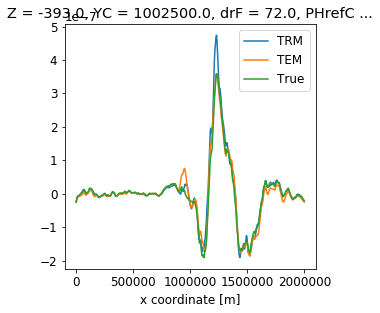

In [179]:
div_TRM_nosav.sel(YC=1e6, Z=-400, method='nearest').plot(label='TRM')
div_TEM_nosav.sel(YC=1e6, Z=-400, method='nearest').plot(label='TEM')
div_fluxT_nosav.sel(YC=1e6, Z=-400, method='nearest').plot(label='True')
plt.legend()